### Import relevant libraries and packages 之后所有Import都放在这里！！

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

sns.set_theme(style='white', palette='rainbow', font_scale=1.2)
import warnings

warnings.filterwarnings('ignore')

## Data quality check
*By Victoria Shi

In [103]:
df = pd.read_csv("data/student-mat.csv")

# preview of dataset
display(df.head())

# basic information about the dataset
print(f"number of rows (Total Number of Students): {df.shape[0]}\nnumber of columns: {df.shape[1]}\ncolumn names\n{list(df.columns)}")

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


number of rows (Total Number of Students): 395
number of columns: 33
column names
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']


In [104]:
# check missing data --> there are no missing values
df.isnull().any().sum()

0

In [105]:
# check the datatypes in the dataframe -> there are object types and the numerical (integer) type.
display(df.dtypes)

num_col = list(df.select_dtypes(include=['int64', 'float64']))
cat_col = list(df.select_dtypes(include=['object']))
# find the exact categorical columns and integer columns respectively
print(f"numerical columns \n{num_col}\n")
print(f"categorical columns: \n{cat_col}")

school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
G3             int64
dtype: object

numerical columns 
['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']

categorical columns: 
['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [106]:
# summary statistics (min and max) of numerical columns -- only want a rough idea of the general range of values instead of the detailed distributions, so min and max would suffice, instead of the mean or standard deviation

df.describe().loc[['min', 'max']].astype(int).T

,min,max
age,15,22
Medu,0,4
Fedu,0,4
traveltime,1,4
studytime,1,4
failures,0,3
famrel,1,5
freetime,1,5
goout,1,5
Dalc,1,5


In [107]:
#Final Grade Distribution
df['G3'].describe()

count    395.000000
mean      10.415190
std        4.581443
min        0.000000
25%        8.000000
50%       11.000000
75%       14.000000
max       20.000000
Name: G3, dtype: float64

In [108]:
# categorical columns
cat_columns = df.select_dtypes(include=['object']).columns

columns = []

# use loop comprehension to  store the column names and the number of unique values
[columns.append([col, df[col].nunique()]) for col in cat_columns]

tally_cat_cols = pd.DataFrame(columns, columns=['Column Name', 'Number of Unique Values'])
tally_cat_cols

,Column Name,Number of Unique Values
0,school,2
1,sex,2
2,address,2
3,famsize,2
4,Pstatus,2
5,Mjob,5
6,Fjob,5
7,reason,4
8,guardian,3
9,schoolsup,2


### Data cleaning and Preparation
*By Victoria Shi(mostly) & Julia Chu (unless indicated)*

From the data quality check, we realized that:

1. While there are no missing values, the data set consists of many categorical variables, so we would need to either encode these variables, dummify them, or convert the data type of these columns from object to numeric.
2. For columns with a yes-no response, we implement a binary mapping of 'yes' to 1 and 'no' to 0.
3. For categorical columns with two unique values, we converted them to 0/1 binary variables, as the choice of 0/1 would not change the result.
4. For columns of categorical variables with more than 2 unique values, we could not map them to numerical values (i.e., mapping distinct values to different integer values) as it would introduce bias due to assuming one value is superior to the other. So instead, we convert them to dummy variables as new predictors.

The code below implements the above cleaning.

In [109]:
######---------------Converting yes-no variables to binary variables----------------#########
# Create a dictionary for binary mapping
binary_mapping = {'yes': 1, 'no': 0}

# Find all columns in the data frame that have 'yes' or 'no' as the response
yes_no_columns = [col for col in df.columns if df[col].isin(['yes', 'no']).any()]

# Apply binary mapping to all columns found in the previous step using a lambda function and pandas' apply method
df[yes_no_columns] = df[yes_no_columns].apply(lambda x: x.map(binary_mapping))

In [110]:
######---------------Manual Feature Selection (this is by Julia)----------------#########

#We are not making distinction among schools. Therefore the variable school will be dropped out.
df["school"].value_counts()
df = df.drop(labels='school', axis=1)

In [111]:
######---------------Transforming predictors with 2 unique values----------------#########

# map categorical variables in data to 0 or 1 if the column has two unique values
#  map the values in the 'school' column to 0 or 1

# map the values in the 'sex' column to 0 or 1
df['sex'] = df['sex'].map({'F': 0, 'M': 1})

# map the values in the 'famsize' column to 0 or 1
# binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3
df['famsize'] = df['famsize'].map({'LE3': 0, 'GT3': 1})

# map the values in the 'address' column to 0 or 1
# binary: 'U' - urban or 'R' - rural
df['address'] = df['address'].map({'R': 0, 'U': 1})

# map the values in the 'Pstatus' column to 0 or 1
# parent's cohabitation status (binary: 'T' - living together or 'A' - apart)
df['Pstatus'] = df['Pstatus'].map({'A': 0, 'T': 1})

In [112]:
######---------------Creating new predictors----------------#########
# Create dummy variables for the 'col' column
target_cols = ['Mjob', 'Fjob', 'reason', 'guardian']
dummies = pd.get_dummies(df.loc[:, target_cols], prefix=['Mjob', 'Fjob', 'reason', 'guardian'])

df.drop(columns=target_cols, inplace=True)

# # Concatenate the original data frame with the dummy variables
df = pd.concat([df, dummies], axis=1)

# combine Dalc and Walc into alc
df.loc[:, 'Alc'] = df['Dalc'] + df['Walc']

# drop Dalc and Walc
df = df.drop(columns=['Dalc', 'Walc'])

# combine Fedu and Medu into famEdu
famEdu = df['Fedu'] + df['Fedu']

df = df.drop(columns=['Fedu', 'Fedu'])

In [113]:
df_all_num2 = df.copy()
df_model_dev = df.copy()

# preview of dataset for training
display(df.head())
# display(df.dtypes)
print(
    f"After cleaning and preparation, the dataset has {df.shape[0]} rows and {df.shape[1]} columns.\nNew columns:\n {list(df.columns)}\nAll columns are of uint8 or integer data types.")

,sex,age,address,famsize,Pstatus,Medu,traveltime,studytime,failures,schoolsup,...,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,Alc
0,0,18,1,1,0,4,2,2,0,1,...,0,1,1,0,0,0,0,1,0,2
1,0,17,1,1,1,1,1,2,0,0,...,0,0,1,0,0,0,1,0,0,2
2,0,15,1,0,1,1,1,2,3,1,...,0,0,0,0,1,0,0,1,0,5
3,0,15,1,1,1,4,1,3,0,0,...,1,0,0,1,0,0,0,1,0,2
4,0,16,1,1,1,3,1,2,0,0,...,0,0,0,1,0,0,1,0,0,3


After cleaning and preparation, the dataset has 395 rows and 43 columns.
New columns:
 ['sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health', 'absences', 'G1', 'G2', 'G3', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'Alc']
All columns are of uint8 or integer data types.


In [114]:
######---------------Describe Statistic & Basic Measures (Julia) ----------------#########
df.describe()

,sex,age,address,famsize,Pstatus,Medu,traveltime,studytime,failures,schoolsup,...,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,Alc
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,...,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,0.473418,16.696203,0.777215,0.711392,0.896203,2.749367,1.448101,2.035443,0.334177,0.129114,...,0.281013,0.073418,0.367089,0.275949,0.091139,0.265823,0.227848,0.691139,0.081013,3.772152
std,0.499926,1.276043,0.416643,0.453690,0.305384,1.094735,0.697505,0.839240,0.743651,0.335751,...,0.450064,0.261152,0.482622,0.447558,0.288172,0.442331,0.419976,0.462610,0.273201,1.984389
min,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,0.000000,16.000000,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,17.000000,1.000000,1.000000,1.000000,3.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000
75%,1.000000,18.000000,1.000000,1.000000,1.000000,4.000000,2.000000,2.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,5.000000
max,1.000000,22.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,3.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000


In [141]:
######---------------Detecting Outliers (Julia) ----------------#########

def detect_outlier(df):

  flag_outlier = False

  for feature in df:
    column = df[feature]
    mean = np.mean(column)
    std = np.std(column)
    z_scores = (column - mean) / std
    outliers = np.abs(z_scores) > 3

    n_outliers = sum(outliers)
    if n_outliers > 0:
      print("{} has {} outliers".format(column, n_outliers))
      flag_outlier = True

    if ~flag_outlier:
      print("The dataset has no outliers.")
    
    return None
  
detect_outlier(df.drop(labels=["G1", "G2", "G3"], axis=1))

The dataset has no outliers.


## Exploratory data analysis

### Part 1
*Julia Chu*

We obtained the following insights after part 1 of data exploration:

- Motivation to take higher education may play a role in the final grade.
- There is a slight difference in grade distribution between genders, but it is not prominent. Statistical significance for gender as a predictor cannot be determined from the graph alone.
- The data points are inconsistent, with only three observations for age 20. There appears to be no clear relationship between age, gender, or their interaction, and the final grade.
- There is not much difference in scores based on geography (rural or urban).
- There may be a high correlation between absences and grades, with grades decreasing as absences increase. The absences are not due to a health condition.

In [115]:
# Data groupBy()... grouping The Data For higher (if they are willing to take higher education)
df.groupby('higher').mean()

,sex,age,address,famsize,Pstatus,Medu,traveltime,studytime,failures,schoolsup,...,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,Alc
higher,,,,,,,,,,,,,,,,,,,,,
0,0.800,17.850000,0.700000,0.700,0.950000,1.950,1.700000,1.400000,1.300000,0.050000,...,0.450,0.050000,0.50,0.150000,0.250000,0.100000,0.200000,0.700000,0.10,4.600
1,0.456,16.634667,0.781333,0.712,0.893333,2.792,1.434667,2.069333,0.282667,0.133333,...,0.272,0.074667,0.36,0.282667,0.082667,0.274667,0.229333,0.690667,0.08,3.728


Number of male students: 0
Number of female students: 0


Text(0, 0.5, 'Count')

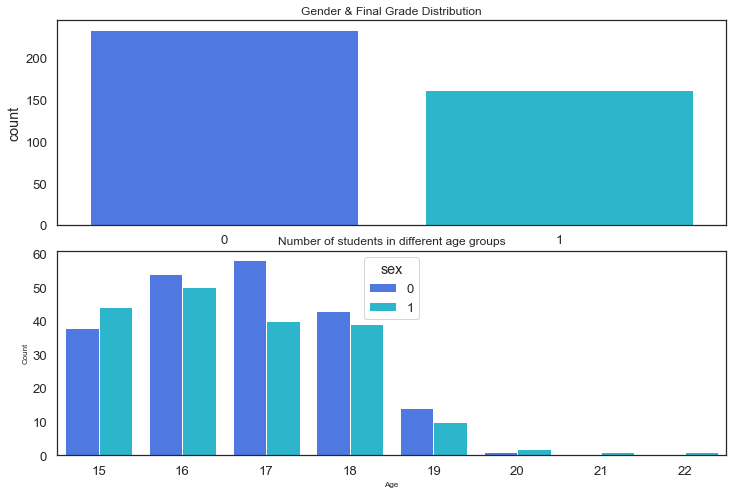

In [138]:
### Age & Gender Distribution and its effect on grade outcome
### Marking Final Grade as Categorical Value & Viewing their Count
male_studs = len(df[df['sex'] == 'M'])
female_studs = len(df[df['sex'] == 'F'])
print('Number of male students:',male_studs)
print('Number of female students:',female_studs)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

df['finalGrade'] = np.where(df['G3'] >= 12, 'Pass', 'Fail')
df['finalGrade'].replace(['Fail', 'Pass'], [0, 1], inplace=True)
gend_pl = sns.countplot(x='finalGrade', data=df, ax=axes[0])
gend_pl.axes.set_title('Gender & Final Grade Distribution', fontsize=12)

fig.subplots_adjust(hspace=0.125, wspace=0.125)

age_pl = sns.countplot(data=df, x='age', hue='sex', ax=axes[1])
age_pl.axes.set_title('Number of students in different age groups', fontsize=12)
age_pl.set_xlabel("Age", fontsize=8)
age_pl.set_ylabel("Count", fontsize=8)

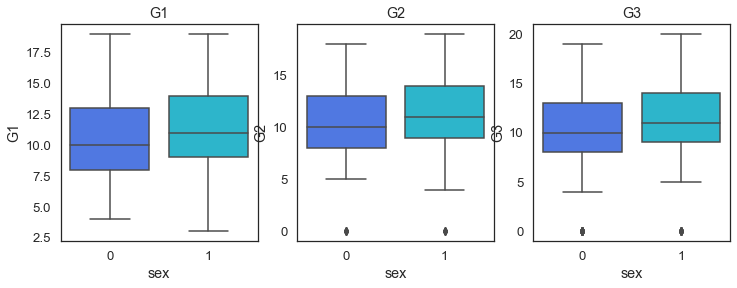

Text(0.5, 1.0, 'Number of students in different age groups')

In [139]:
#Whether there's a gender difference in grade distribution in G1 G2 AND G3
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax1 = sns.boxplot(data=df, x='sex', y='G1', ax=axes[0])
ax1.set_title('G1')
ax2 = sns.boxplot(data=df, x='sex', y='G2', ax=axes[1])
ax2.set_title('G2')
ax3 = sns.boxplot(data=df, x='sex', y='G3', ax=axes[2])
ax3.set_title('G3')
plt.show()
age_pl.axes.set_title('Number of students in different age groups', fontsize=12)


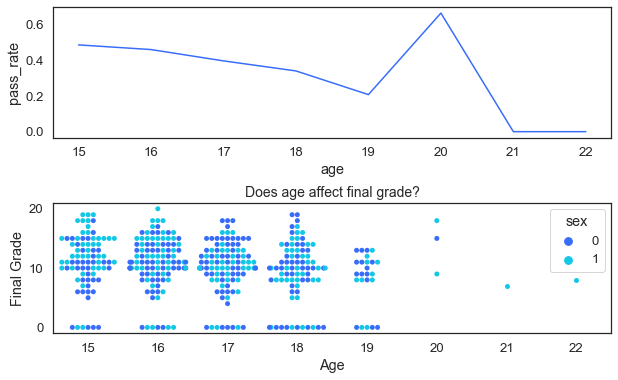

In [118]:
#Whether there's a gender difference in grade distribution in G1 G2 AND G3
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
age_data = df.groupby('age')['finalGrade'].agg([('pass_rate', 'mean'), ('nobs', 'count')]).reset_index(drop=False)
age_pass = sns.lineplot(x=age_data.age, y=age_data['pass_rate'], ax=axes[0])

fig.subplots_adjust(hspace=0.5, wspace=0.125)
b = sns.swarmplot(x='age', y='G3',hue='sex', data=df, ax=axes[1])
b.axes.set_title('Does age affect final grade?', fontsize = 14)
b.set_xlabel('Age')
b.set_ylabel('Final Grade')
plt.show()

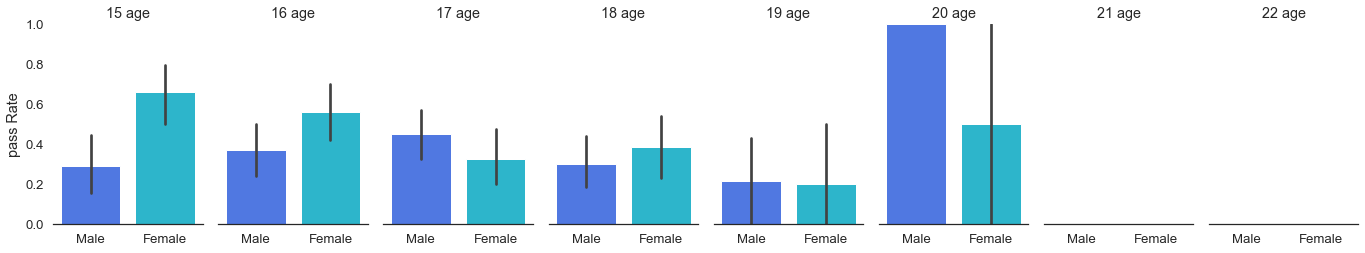

In [119]:
g = sns.catplot(data=df, x="sex", y="finalGrade", col="age",kind="bar", height=4, aspect=.6,ax=axes[0])
g.set_axis_labels("", "pass Rate")
g.set_xticklabels(["Male", "Female"])
g.set_titles("{col_name} {col_var}")
g.set(ylim=(0, 1))
g.despine(left=True)

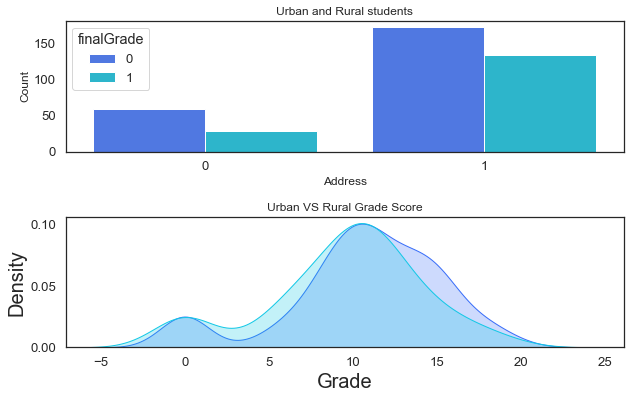

In [137]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

#Whether geography affects grade outcome 
add_plt = sns.countplot(data=df, x='address', hue="finalGrade", ax=axes[0])
add_plt.axes.set_title('Urban and Rural students', fontsize=12)
add_plt.set_xlabel('Address', fontsize=12)
add_plt.set_ylabel('Count', fontsize=12)

fig.subplots_adjust(hspace=0.5, wspace=0.125)

# Grade distribution by address
sns.kdeplot(df.loc[df['address'] == 1, 'G3'], label='Urban', shade = True, ax=axes[1])
sns.kdeplot(df.loc[df['address'] == 0, 'G3'], label='Rural', shade = True, ax=axes[1])
plt.title('Urban VS Rural Grade Score', fontsize = 12)
plt.xlabel('Grade', fontsize = 20);
plt.ylabel('Density', fontsize = 20)
plt.show()

<AxesSubplot:xlabel='health', ylabel='absences'>

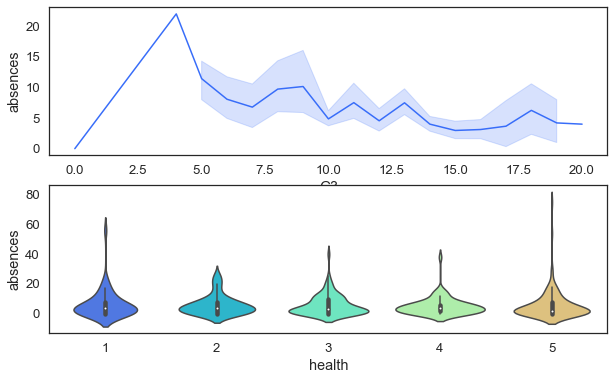

In [144]:
#Grade distribution by Absences, and whether absences are correlated with health condition
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

sns.lineplot(df['G3'],df['absences'], ax=axes[0])
sns.violinplot(df['health'],df['absences'], ax=axes[1])

### Part 2
*Victoria Shi*

Text(0.5, 1.0, 'Grade (Binary) Distribution')

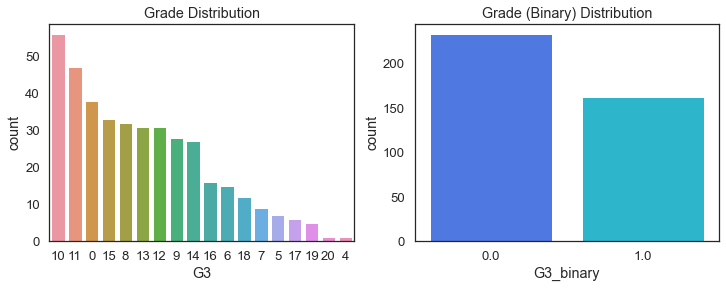

In [121]:
data = pd.read_csv("data/student-mat.csv")
# Create a new column 'G3_binary' in the data frame
# Assign 0 to all rows where G3 is less than 12
data.loc[data.G3 < 12, 'G3_binary'] = 0

# Assign 1 to all rows where G3 is greater than or equal to 12
data.loc[data.G3 >= 12, 'G3_binary'] = 1

fig = plt.figure(figsize=(12, 4))
# Plot a count plot of the 'G3' column and set the title
fig.add_subplot(1, 2, 1)
sns.countplot(x='G3', data=data, order=data['G3'].value_counts().index).set_title("Grade Distribution")

# Plot a count plot of the 'G3_binary' column and set the title
fig.add_subplot(1, 2, 2)
sns.countplot(x=data.G3_binary, order=data.G3_binary.value_counts().index).set_title("Grade (Binary) Distribution")

Text(0.5, 1.0, 'Pairwise correlation among (innately) numerical columns')

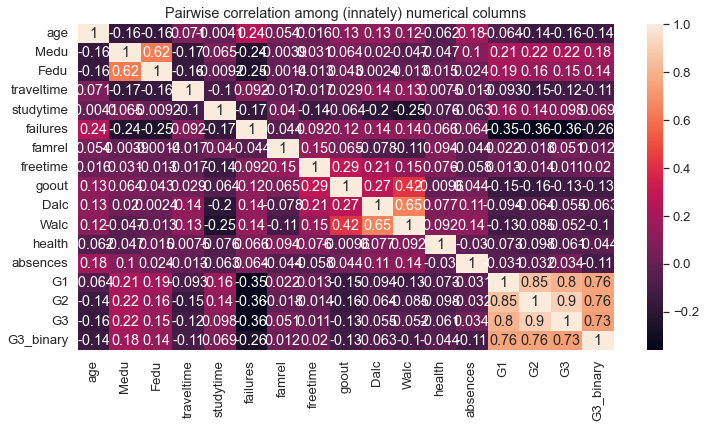

In [122]:
plt.figure(figsize=(12, 6))
# plot the correlation among variables that are ORIGINALLy numerical
sns.heatmap(data.corr(), annot=True).set_title("Pairwise correlation among (innately) numerical columns")

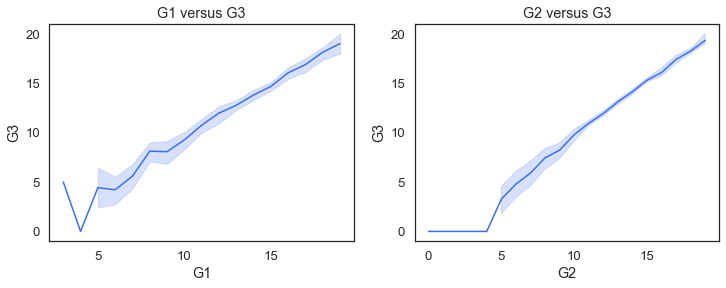

Text(0.5, 1.0, 'G1, G2, and G3')

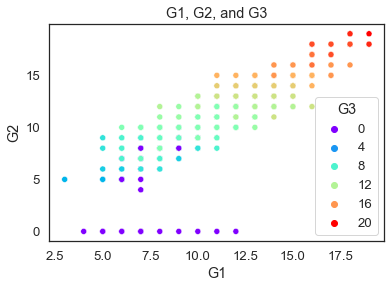

In [123]:
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(1, 2, 1)
sns.lineplot(x='G1', y='G3', data=data).set_title('G1 versus G3')
fig.add_subplot(1, 2, 2)
sns.lineplot(x='G2', y='G3', data=data).set_title('G2 versus G3')
plt.show()

sns.scatterplot(x='G1', y='G2',hue='G3', palette='rainbow', data=data).set_title('G1, G2, and G3')

In [124]:
# Since G1, G2, and G3 are highly correlated, we remove G2 and G3
data = data.drop(columns=["G1", "G2"])

`G1` and `G2` are strongly correlated themselves and are strongly correlated with `G3`. SO we remove G1 and G2.
`Medu` and `Fedu` are strongly correlated. `Dalc` and `Walc` are strongly correlated.

In [125]:
data['famEdu'] = data['Fedu'] + data['Medu']

data['Alc'] = data['Walc'] + data['Dalc']

data = data.drop(columns=["Fedu", 'Medu', 'Walc', 'Dalc', 'G3_binary'])

Text(0.5, 1.0, 'Pairwise correlation')

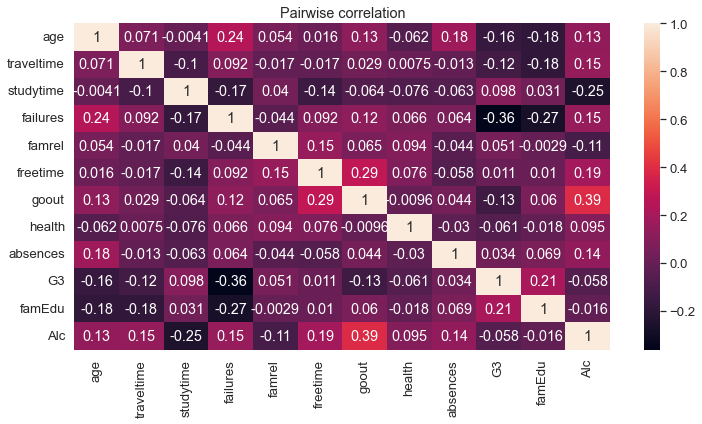

In [126]:
fig = plt.figure(figsize=(12, 6))
sns.heatmap(data.corr(), annot=True).set_title("Pairwise correlation")

Text(0.5, 1.0, 'freetime vs G3')

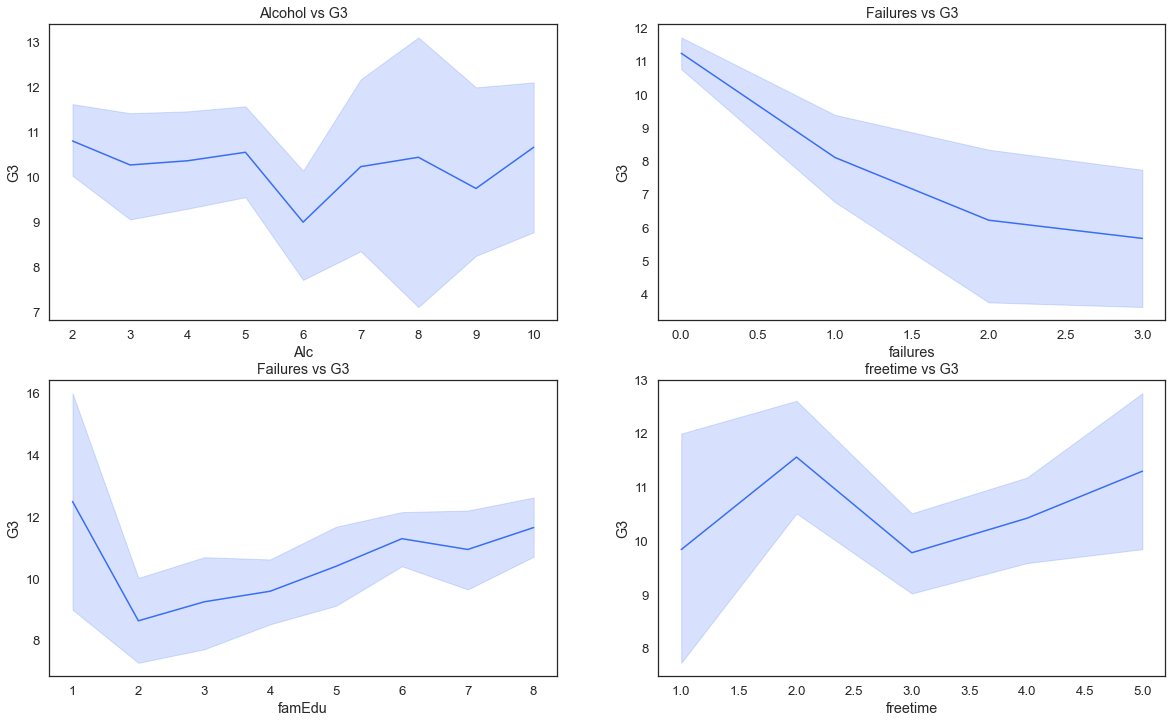

In [127]:
fig = plt.figure(figsize=(20, 12))
fig.add_subplot(2, 2, 1)
sns.lineplot(x='Alc', y='G3', data=data).set_title('Alcohol vs G3')
fig.add_subplot(2, 2, 2)
sns.lineplot(x='failures', y='G3', data=data).set_title('Failures vs G3')
fig.add_subplot(2, 2, 3)
sns.lineplot(x='famEdu', y='G3', data=data).set_title('Failures vs G3')
fig.add_subplot(2, 2, 4)
sns.lineplot(x='freetime', y='G3', data=data).set_title('freetime vs G3')

#### Important Categorical Predictors

Text(0.5, 1.0, 'freetime vs G3')

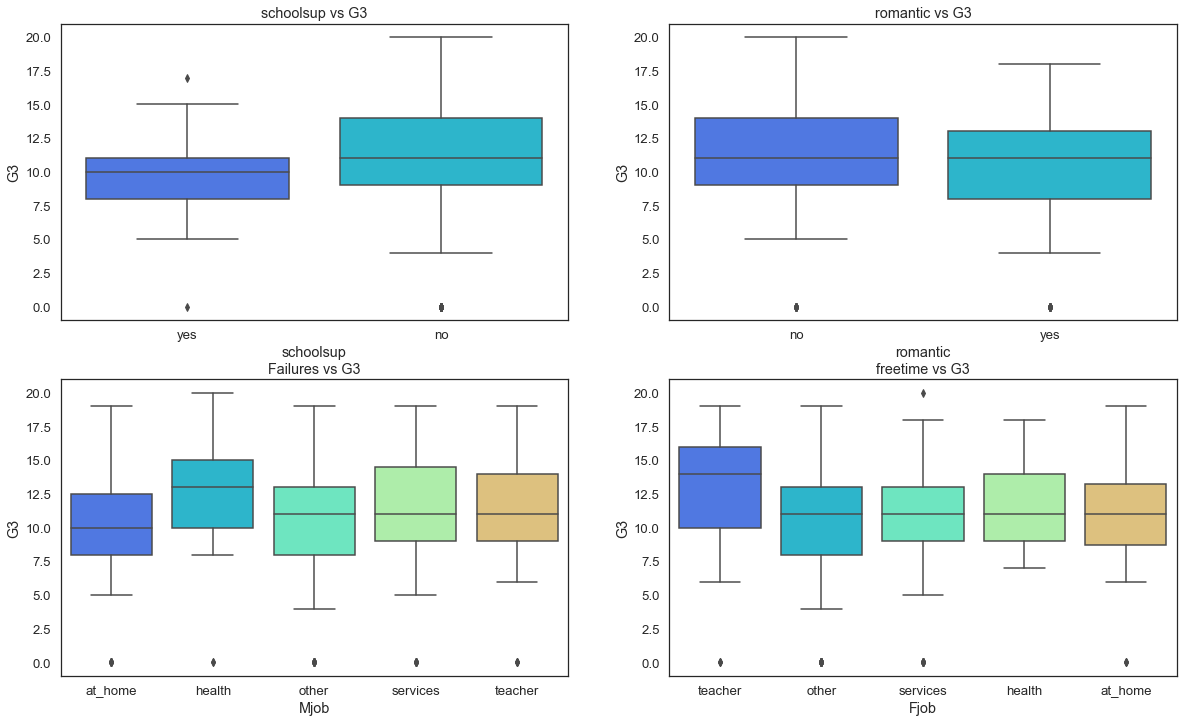

In [128]:
data = pd.read_csv("data/student-mat.csv")
fig = plt.figure(figsize=(20, 12))
fig.add_subplot(2, 2, 1)
sns.boxplot(x='schoolsup', y='G3', data=data).set_title('schoolsup vs G3')
fig.add_subplot(2, 2, 2)
sns.boxplot(x='romantic', y='G3', data=data).set_title('romantic vs G3')
fig.add_subplot(2, 2, 3)
sns.boxplot(x='Mjob', y='G3', data=data).set_title('Failures vs G3')
fig.add_subplot(2, 2, 4)
sns.boxplot(x='Fjob', y='G3', data=data).set_title('freetime vs G3')

#### EDA for Nested Model
*Yuyan Zhang*

#### EDA for Progress Model
*Yiru Zhang*

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

#### Base Model Development
*Victoria*

In [129]:
######-----------Shuffling the dataset via train-test split for K-fold------------#########

# Import the train_test_split and KFold function
from sklearn.model_selection import train_test_split, KFold

# create a copy of the cleaned and transformed data frame and assign it to data (for base model development)
data = df.copy()
predictor_cols = [col for col in data.columns.tolist() if col not in ['G1', 'G2', 'G3']]

X = data[predictor_cols]

y = data.G3

# Define the KFold cross-validation object with 10 splits, a random state of 1, and shuffling enabled
k_fold = KFold(n_splits=10, random_state=1, shuffle=True)

# Split the data into training and test sets using the train_test_split function
# The test set will be 20% of the total data and the random state is set to 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(f"dimension of training set: {X_train.shape}\ndimension of testing set: {X_test.shape}")

dimension of training set: (316, 41)
dimension of testing set: (79, 41)


#### Important Predictors (Overall)

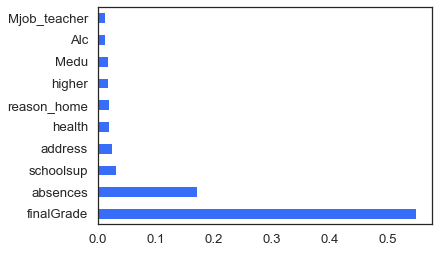

In [130]:
# Import the DecisionTreeRegressor class
from sklearn.tree import DecisionTreeRegressor

# Initialize a DecisionTreeRegressor object and set the random state to 1 for reproducibility
model_tree = DecisionTreeRegressor(random_state=1)

# Fit the model to the training data
model_tree.fit(X_train, y_train)

# Create a pandas Series object to store the feature importance
importance = pd.Series(model_tree.feature_importances_, index=X.columns)

# Plot the 10 largest feature importance using a horizontal bar plot
importance.nlargest(10).plot(kind='barh')
plt.show()

#### Important Categorical Predictors

In [131]:
from sklearn.feature_selection import SelectKBest, chi2

In [132]:
X_cat = X.drop(columns='Alc')

# Select only categorical columns from the dataframe X_cat
X_cat = X_cat.loc[:, [col for col in X_cat.columns if col not in num_col]]

# Apply SelectKBest with chi-square test to select the best 5 features
k_best = SelectKBest(score_func=chi2, k=5).fit(X_cat, y)

# Create a pandas series to store the scores of each feature
df_score = pd.Series(data=k_best.scores_, index=X_cat.columns)

# Sort the scores in descending order
df_score.sort_values(ascending=False)[:5]

finalGrade      233.000000
schoolsup        28.319018
Fjob_teacher     23.133348
Mjob_at_home     22.615347
Mjob_health      22.416110
dtype: float64

In [133]:
# concatenate X_train and y_train so that predictors and response are in the same dataset
train = pd.concat([X_train, y_train], axis=1)

# concatenate X_test and y_test so that predictors and response are in the same dataset
test = pd.concat([X_test, y_test], axis=1)

In [134]:
# function to test prediction accuracy
def acc(_lm, _Xtest, _ytest):
    y_pred = _lm.predict(_Xtest)
    df = pd.concat([y_pred, _ytest], axis=1)
    test_res = pd.DataFrame(df, columns=["predicted", "actual"], dtype="float64")
    test_res[y_pred < 12], test_res[y_pred >= 12] = 0, 1
    test_res[y_pred < 6], test_res[y_pred >= 12] = 0, 1
    y_test[y_test < 12], y_test[y_test >= 12] = 0, 1
    return np.mean(test_res.predicted == test_res.actual)


# function to format and print result
def display_res(lm_formula):
    lm = smf.ols(formula=lm_formula, data=train).fit()
    r2 = lm.rsquared
    acc_test = acc(lm, test, y_test)
    acc_full = acc(lm, X, y)
    print(f"{lm_formula}\nR-Squared = {r2:.4f}\nAccuracy on test set: {acc_test}\tfull dataset: {acc_full}")

In [135]:
lm0 = 'G3 ~ absences'
display_res(lm0)

lm1 = 'G3 ~ absences + failures'
display_res(lm1)

lm2 = 'G3 ~ absences * failures'
display_res(lm2)

G3 ~ absences
R-Squared = 0.0016
Accuracy on test set: 1.0	full dataset: 1.0
G3 ~ absences + failures
R-Squared = 0.1237
Accuracy on test set: 1.0	full dataset: 1.0
G3 ~ absences * failures
R-Squared = 0.1516
Accuracy on test set: 1.0	full dataset: 1.0


### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.